In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from collections import Counter

In [3]:
def add_new(start, end, collection, check_last=False):
    if check_last and collection:
        last_start, last_end = collection[-1]
        if start <= last_end:
            collection[-1] = (last_start, end)
            return
    collection.append((start, end))
        
        
def load_file(f_name, start_col=0, stop_col=2):
    df = pd.read_csv(f_name, header=None, sep='\t')
    df = df.loc[:, start_col:stop_col]
    df = df.rename(columns={i: col for i, col in zip(range(start_col, stop_col+1), ['chr', 'start', 'stop'])})
    df = df[df.apply(lambda row: row['chr'][3:].isdigit(), axis=1)]
    return df
    
        
def load_boundaries(f_name):
    boundaries = pd.read_csv(f_name, header=None, sep='\t')
    boundaries = boundaries.rename(columns={0:'chr', 1:'boundary'})
    boundaries = boundaries[boundaries.apply(lambda row: row['chr'][3:].isdigit(), axis=1)]
    return boundaries.set_index('chr')

In [4]:
df = load_file('./data/cpgIslandExt.txt', start_col=1, stop_col=3)
df['chr'].value_counts()

chr19    2541
chr1     2462
chr2     1688
chr17    1634
chr7     1578
chr16    1491
chr11    1367
chr6     1253
chr5     1229
chr9     1226
chr12    1221
chr3     1163
chr10    1143
chr8     1037
chr4     1031
chr20     801
chr15     792
chr14     788
chr22     719
chr13     605
chr18     507
chr21     365
Name: chr, dtype: int64

In [5]:
df = load_file('./data/wgEncodeHaibMethyl450A549Etoh02SitesRep1.bed')
df['chr'].value_counts()

chr1     46567
chr6     36438
chr2     34501
chr7     29844
chr11    28654
chr17    27775
chr19    25449
chr3     24996
chr12    24385
chr10    24212
chr5     24168
chr16    21876
chr8     20787
chr4     20276
chr15    15146
chr14    14987
chr13    12175
chr20    10302
chr9      9736
chr22     8502
chr18     5889
chr21     4205
Name: chr, dtype: int64

In [6]:
def check_stat(pos, layers):
    for layer, positions in layers.items():
        for start, end in positions:
            if pos < end and pos >= start:
                return layer
    raise RuntimeError()
                

def compute_batch(df, results):
    stats = []
    for i, row in df.iterrows():
        pos = (row['stop']+row['start'])//2
        layer = check_stat(pos, results[row['chr']])
        stats.append(layer)
    return Counter(stats)


class BedStats:
    def __init__(self, size, boundaries, num_workers=8):
        self.size = size
        self.boundaries = load_boundaries(boundaries)
        self.num_workers = num_workers
        
    def compute_statistics(self, cgd_file, stat_file, out_dir):
        results = self._convert(cgd_file)
        self._save(results, out_dir)
        return self._compute_statistics(results, stat_file)
            
    def _compute_statistics(self, results, stat_file):
        df = load_file(stat_file)
        batch_size = len(df) // self.num_workers
        batches = [df.iloc[i*batch_size:(i+1)*batch_size] if i < self.num_workers - 1 else
                   df.iloc[i*batch_size:] for i in range(self.num_workers)]
        
        with Pool(processes=self.num_workers) as p:
            stats = p.starmap(compute_batch, zip(batches, itertools.repeat(results, self.num_workers)))
            
        for i in range(1, len(stats)):
            stats[0].update(stats[i])
        return stats[0]
        
    def _convert(self, file):
        df = load_file(file, start_col=1, stop_col=3)
        results = {}
        for chromosome in self.boundaries.index:
            chr_df = df[df['chr'] == chromosome]
            results[chromosome] = self._convert_chromosome(chr_df, self.boundaries.loc[chromosome, 'boundary'])
        return results
    
    def _convert_chromosome(self, df, boundary):
        collection = {
            'CpG': [],
            'Shore': [],
            'Shelf': [],
            'Sea': []
        }
        df = df.sort_values(by='start', ascending=True)
        self._check_boundary(df.iloc[0]['start'], -self.size, 0, collection)
        add_new(df.iloc[0]['start'], df.iloc[0]['stop'], collection['CpG'])
        
        for i in range(len(df)-1):
            start_a, stop_a, start_b, stop_b = df.iloc[i]['start'], df.iloc[i]['stop'], df.iloc[i+1]['start'], df.iloc[i+1]['stop']
            if start_b <= stop_a: 
                add_new(start_a, stop_b, collection['CpG'], check_last=True)
                continue
            add_new(start_b, stop_b, collection['CpG'], check_last=True)
            
            # first shore is in range (stop_a, shore_a), second in range (shore_b, start_b)
            shore_a, shore_b = stop_a + self.size, start_b - self.size
            if self._check_layer(stop_a, shore_a, start_b, shore_b, collection['Shore']):
                continue

            # first shelf is in range (shore_a, shelf_a), second in range (shelf_b, shore_b)
            shelf_a, shelf_b = shore_a + self.size, shore_b - self.size
            if self._check_layer(shore_a, shelf_a, shore_b, shelf_b, collection['Shelf']):
                continue
                
            # sea is in range (shelf_a, shelf_b)
            add_new(shelf_a, shelf_b, collection['Sea'])

        self._check_boundary(df.iloc[len(df)-1]['stop'], self.size, boundary, collection)
        return collection
    
    def _check_layer(self, old_a, new_a, old_b, new_b, collection):
        # layer might be from old_a to new_a and from new_b to old_b OR from old_a to old_b
        if new_b <= new_a: 
            add_new(old_a, old_b, collection)
            return 1
        
        add_new(old_a, new_a, collection)
        add_new(new_b, old_b, collection)
        return 0
    
    def _check_boundary(self, cpg, change, boundary, collection):
        fun = max if boundary == 0 else min
        shore = fun(cpg + change, boundary)
        if boundary == 0: add_new(shore, cpg, collection['Shore'])
        else: add_new(cpg, shore, collection['Shore'])
            
        if shore != boundary:
            shelf = fun(shore + change, boundary)
            if boundary == 0: add_new(shelf, shore, collection['Shelf'])
            else: add_new(shore, shelf, collection['Shelf'])
            
            if shelf != boundary:
                if boundary == 0: add_new(0, shelf, collection['Sea'])
                else: add_new(shelf, boundary, collection['Sea'])
                    
    def _save(self, results, out_dir):
        final = {'CpG': [], 'Shore': [], 'Shelf': [], 'Sea': []}
        for chromosome, chr_results in results.items():
            for type_, positions in chr_results.items():
                chr_type_dict = {
                    'chr': [chromosome] * len(positions),
                    'start': [p for p, _ in positions],
                    'end': [p for _, p in positions],
                }
                chr_type_df = pd.DataFrame.from_dict(chr_type_dict)
                final[type_].append(chr_type_df)
                
        for type_, chr_dfs in final.items():
            type_df = pd.concat(chr_dfs, axis=0, ignore_index=True)
            type_df.to_csv(os.path.join(out_dir, f'{type_}.bed'), sep='\t', header=False, index=False)
                
            

In [7]:
x = BedStats(size=2*8*2**10, boundaries='./data/hg19.chrom.sizes')
stats = x.compute_statistics('./data/cpgIslandExt.txt', './data/wgEncodeHaibMethyl450A549Etoh02SitesRep1.bed', './output/2kb')
stats

Counter({'Shore': 218145, 'Sea': 89262, 'CpG': 132094, 'Shelf': 31369})

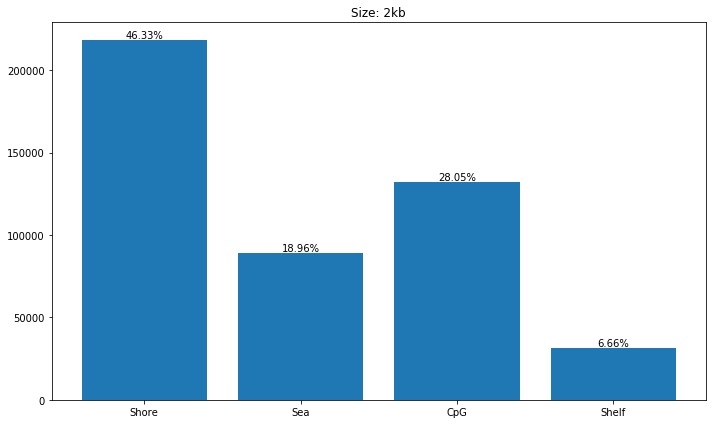

In [8]:
plt.figure(figsize=(10, 6))
bar = plt.bar(range(4), stats.values())
plt.xticks(range(4), stats.keys())
percent = [str(round(v/sum(stats.values())*100, 2)) + '%' for v in stats.values()]
for rect, p in zip(bar, percent):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height, p, ha='center', va='bottom')
plt.title('Size: 2kb')
plt.tight_layout()
None

In [9]:
x = BedStats(size=2000, boundaries='./data/hg19.chrom.sizes')
stats = x.compute_statistics('./data/cpgIslandExt.txt', './data/wgEncodeHaibMethyl450A549Etoh02SitesRep1.bed', './output/2k')
stats

Counter({'Shore': 122913, 'Sea': 170406, 'CpG': 132094, 'Shelf': 45457})

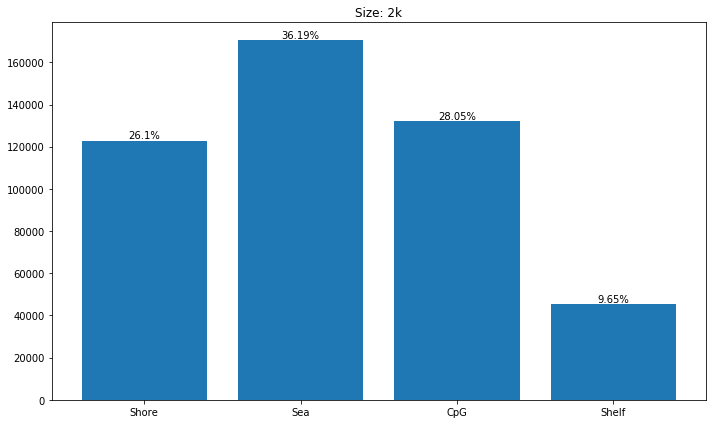

In [10]:
plt.figure(figsize=(10, 6))
bar = plt.bar(range(4), stats.values())
plt.xticks(range(4), stats.keys())
percent = [str(round(v/sum(stats.values())*100, 2)) + '%' for v in stats.values()]
for rect, p in zip(bar, percent):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height, p, ha='center', va='bottom')
plt.title('Size: 2k')
plt.tight_layout()
None